# Small noise approximation - mRNA level

In [3]:
import glob
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# figdir = '../../fig/chemical_master_analytic_protein/'
tmpdir = '../../tmp/'

### $\LaTeX$ macros

$\newcommand{\meanm}{\langle m \rangle}$
$\newcommand{\rm}{r_m}$
$\newcommand{\gm}{\gamma_m}$
$\newcommand{\kon}{k_{\text{on}}}$
$\newcommand{\koff}{k_{\text{off}}}$
$\newcommand{\depsilon}{\Delta \varepsilon}$

## The small noise approximation.

In this notebook we will explore the use of the small noise approximation in the context of the information processing capacity of the simple repression motif at steady state focusing on the mRNA level.

As derived by Tkacik, Callan and Bialek in their [2008 Phys Rev E paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.78.011910), if one assumes the small noise approximation is valid, computing the channel capacity of a genetic regulatory system becomes analytically tractable.
The calculation requires a mapping between the input (in our case $c$ the inducer concentration) and the **mean output** (for this particular notebook the mean mRNA copy number $\meanm$). Since these means are deterministic functions of the input we can use the change of variables
$$
P_c(c) dc = P_{\meanm} (\meanm) d \meanm.
$$
In that case the optimal distribution $P^*_c(c)$ can be mapped to the optimal mean output distribution $P^*_{\meanm}(\meanm)$.

Using this change of variables and the small noise approximation (SMA) the optimal mean output distribution is given by
$$
P^*(\meanm) = {1 \over \mathcal{Z}} {1 \over \sigma_{\meanm}(\meanm)},
$$
where $\mathcal{Z}$ is a normalization constant of the form
$$
\mathcal{Z} = \int_{\meanm _\min}^{\meanm _\max} 
              {d\meanm \over \sigma_{\meanm}\left( \meanm \right)}.
$$

Giventhis optimal distribution it can be shown that the channel capacity 
$I^*(c;\meanm)$ is given by
$$
I^*(c;\meanm) = \log_2 \left( {\mathcal{Z} \over \sqrt{2\pi e}} \right).
$$

So with this amazing and simple result all we need is an expression for the noise $\sigma_{\meanm}$ as a function of the mean output $\meanm$ in order to compute the channel capacity of our system of interest!

## mRNA level channel capacity.
As derived using the two-state promoter chemical master equation the mean mRNA copy number at this level is given by
$$
\meanm = {\rm \over \gm}{\kon \over \kon + \koff},
$$
where $\rm$ is the mRNA production rate $\gm$ is the degradation rate, $\kon$ is the rate to transition from inactive to active promoter and $\koff$ is the rate to transition from active to inactive.

The variance in gene expression again as derived using chemical master equations is of the form
$$
\sigma_{\meanm}^2 = \meanm \left( 1 + {\koff \over \kon + \koff}
                            {\rm \over \koff + \kon + \gm}\right).
$$

For the case of the induction we have that $\meanm \equiv \meanm(\koff)$, i.e. the only variable that changes as we increase the induction concentration is assumed to be the rate $\koff$. That means that in performing the integral to compute $\mathcal{Z}$ we have to take into account the fact that this rate will change within the limits of the integral. To account for that let's use the expression for the mean mRNA copy number and solve for $\koff$

**Note: This has already been done manually but I'll implement an algebraic solver with `sympy` to double check the results.**

In [22]:
# Define the sympy variables
r, gamma = sympy.symbols('r gamma')
kon, koff = sympy.symbols('k_{{on}} k_{{off}}')
mm = sympy.Symbol('\\langle m \\rangle')
sigmam = sympy.Symbol('\\sigma_{\\langle m \\rangle}')

r, gamma, kon, koff, mm, sigmam

Having defined the variables let's find the expression that connects $\meanm$ with $\koff$

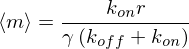

In [25]:
# Define the equation for the mean mRNA copy number
mean_mRNA = sympy.Eq(mm , (r / gamma) * kon / (kon + koff))
mean_mRNA

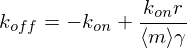

In [32]:
# Solve the equation for koff to find a relationship between koff and <m>
koff_m_func = sympy.solve(mean_mRNA, koff)[0]
sympy.Eq(koff, koff_m_func)

Having this relationship allow us to now use the equation for the variance in mRNA copy number. Let's declare the `sympy` function for the variance

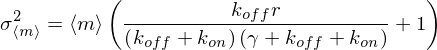

In [34]:
# Define function for variance
var_mRNA = mm * (1 + koff / (kon + koff) * r / (kon + koff + gamma))
sympy.Eq(sigmam**2, var_mRNA)

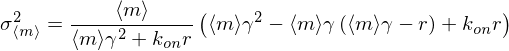

In [42]:
# Substitute koff for the relationship with mean mRNA
var_mRNA_m_func = sympy.simplify(var_mRNA.subs(koff, koff_m_func))

sympy.Eq(sigmam**2, var_mRNA_m_func)

Having this expression let's check if sympy can perform the integral for this case.

In [ ]:
# Z_int = sympy.integrate(1 / sympy.sqrt(var_mRNA_m_func), mm)

It seems that `sympy` cannot solve this integral. Mathematica on the other side can solve the integral and it is a horrible and useless equation. The numerical integration will be the actual intuitive result for this. Nevertheless here is Mathematica's result
$$\scriptstyle{
-\frac{2 \sqrt{2} m \sqrt{-\frac{k r+\gamma ^2 m}{\gamma  m \left(-\gamma +\sqrt{4 k r+(\gamma +r)^2}+r\right)}} \left(\sqrt{\frac{-\gamma  m \left(\gamma -\sqrt{4 k
   r+(\gamma +r)^2}+r\right)-2 k r}{\gamma  m \sqrt{4 k r+(\gamma +r)^2}}} \left(\gamma  m (\gamma +r) \left(\gamma +\sqrt{4 k r+(\gamma +r)^2}+r\right)+k r \left(\gamma
   +\sqrt{4 k r+(\gamma +r)^2}+2 \gamma  m+r\right)\right) F\left(\sin ^{-1}\left(\frac{\sqrt{\frac{\frac{2 k r}{m}+\gamma  \left(r+\gamma +\sqrt{(r+\gamma )^2+4 k
   r}\right)}{\gamma  \sqrt{(r+\gamma )^2+4 k r}}}}{\sqrt{2}}\right)|\frac{2 \sqrt{(r+\gamma )^2+4 k r}}{r-\gamma +\sqrt{(r+\gamma )^2+4 k r}}\right)-2 \gamma ^2 m
   \sqrt{4 k r+(\gamma +r)^2} \sqrt{-\frac{k r (k r+\gamma  m (\gamma -\gamma  m+r))}{\gamma ^2 m^2 \left(4 k r+(\gamma +r)^2\right)}} \sqrt{\frac{\frac{2 k r}{m}+\gamma 
   \left(\gamma +\sqrt{4 k r+(\gamma +r)^2}+r\right)}{\gamma  \sqrt{4 k r+(\gamma +r)^2}}} \Pi \left(\frac{2 \sqrt{(r+\gamma )^2+4 k r}}{r+\gamma +\sqrt{(r+\gamma )^2+4 k
   r}};\sin ^{-1}\left(\frac{\sqrt{\frac{\frac{2 k r}{m}+\gamma  \left(r+\gamma +\sqrt{(r+\gamma )^2+4 k r}\right)}{\gamma  \sqrt{(r+\gamma )^2+4 k
   r}}}}{\sqrt{2}}\right)|\frac{2 \sqrt{(r+\gamma )^2+4 k r}}{r-\gamma +\sqrt{(r+\gamma )^2+4 k r}}\right)\right)}{\left(\gamma +\sqrt{4 k r+(\gamma +r)^2}+r\right)
   \left(k r+\gamma ^2 m\right) \sqrt{\frac{m (k r+\gamma  m (\gamma -\gamma  m+r))}{k r+\gamma ^2 m}} \sqrt{\frac{\frac{2 k r}{m}+\gamma  \left(\gamma +\sqrt{4 k
   r+(\gamma +r)^2}+r\right)}{\gamma  \sqrt{4 k r+(\gamma +r)^2}}}}
   }
$$

## Numerical exploration of the channel capacity.

Given the unintuitive form of this equation we will make use of numerical integration to explore how different parameters affect the channel capacity.

First we define the inverse standard deviation function and generate a `lambdify` function to evaluate this expression numerically.

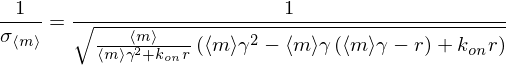

In [47]:
# Define the inverse standard deviation 
inv_sigma = 1 / sympy.sqrt(var_mRNA_m_func)
sympy.Eq(1 / sigmam, inv_sigma)

In [49]:
# Generate lambdify function
imv_sigma_num = sympy.lambdify([mm, kon, r, gamma], inv_sigma, 'numpy')

### Limits of integration

The limits of integration to compute $\mathcal{Z}$ are $\meanm_\min$ and $\meanm_\max$. These limits indicate the mean number of mRNA produce in the absence of inducer ($\meanm_\min$) and the mRNA copy number at saturating concentrations of inducer ($\meanm_\max$).

These limits are given as (derivation show elsewhere):
$$
\meanm_\min = {\rm \over \gm} 
{1 \over {k_o \left[ R \right] \over \kon} \left( {1 \over 1 + e^{-\beta \depsilon_{AI}}} \right)},
$$
where $\depsilon_{AI}$ is the energy difference between the active and inactive state of the repressor. For the upper bound we have
$$
\meanm_\max = {\rm \over \gm} 
{1 \over {k_o \left[ R \right] \over \kon} \left( {1 \over 1 + e^{-\beta \depsilon_{AI}} \left( {K_A \over K_I} \right)^2 } \right)},
$$